In [5]:
import torch
import ray
from ray import tune
from sklearn.model_selection import train_test_split
import yaml
import argparse
import shutil
from collections import namedtuple
import os
import datetime
from pennylane import numpy as np

# Custom Libraries
from utils.model import Qkernel
from utils.data_generator import DataGenerator
from utils.agent import TrainModel
from utils.plotter import Plotter
from utils.helper import to_python_native, gen_experiment_name, set_seed

In [12]:
data_generator = DataGenerator(
        dataset_name='checkerboard',
        file_path='/home/digvijay/Documents/developer/greedy_kernel_alignment/data/checkerboard_dataset.npy',
    )

features, target = data_generator.generate_dataset()
training_data, testing_data, training_labels, testing_labels = train_test_split(features, target, test_size=0.50, random_state=42)
training_data = torch.tensor(training_data.to_numpy(), dtype=torch.float32, requires_grad=True)
testing_data = torch.tensor(testing_data.to_numpy(), dtype=torch.float32, requires_grad=True)
training_labels = torch.tensor(training_labels.to_numpy(), dtype=torch.int)
testing_labels = torch.tensor(testing_labels.to_numpy(), dtype=torch.int)

def _get_centroids(training_data, training_labels):
    data = training_data.detach().numpy()
    data_labels = training_labels.detach().numpy()
    _class_centroids = []
    _class_centroids_labels = []
    _main_centroids = []
    for c in [1, -1]:
        cdata = data[data_labels == c]
        mc = [np.mean(cdata, axis=0)]
        _main_centroids.append(torch.tensor(np.array(mc), requires_grad= True))
        sub_centroids = [np.mean(cluster, axis=0) for cluster in np.array_split(cdata, 4)]
        sub_centroids_labels = [c] * 4
        class_centroids = np.array(mc + sub_centroids)
        _class_centroids.append(torch.tensor(class_centroids, requires_grad=True))
        _class_centroids_labels.append(torch.tensor(np.array(sub_centroids_labels)))
    return _class_centroids, _class_centroids_labels, _main_centroids

_class_centroids, _class_centroids_labels, _main_centroids = _get_centroids(training_data, training_labels)

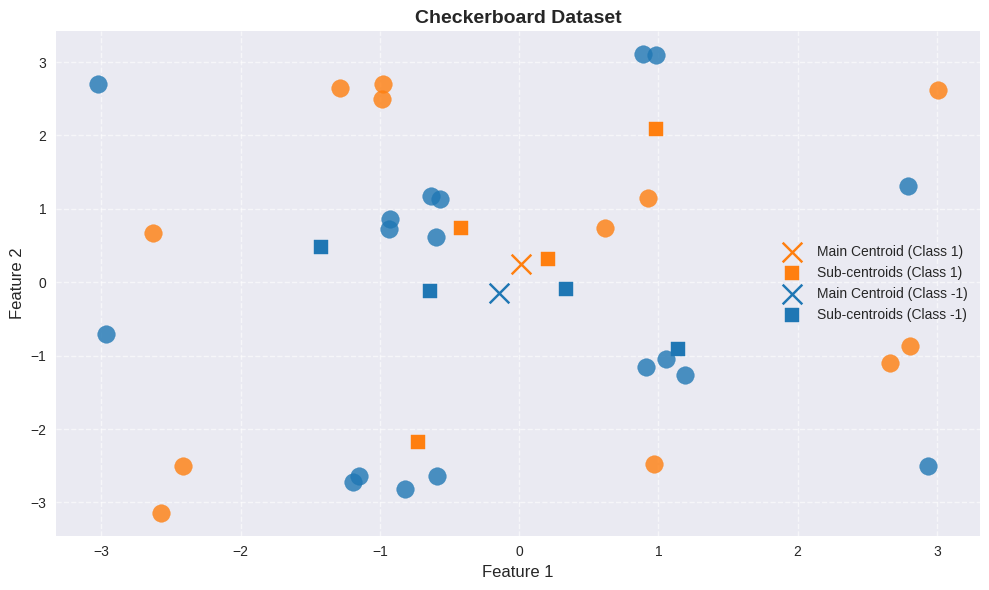

In [17]:
import matplotlib.pyplot as plt

# Convert tensors to NumPy arrays for plotting
training_data_np = training_data.detach().numpy()
training_labels_np = training_labels.detach().numpy()

def plot_dataset_and_centroids(train_features, train_labels, test_features, test_labels, _main_centroids, _class_centroids, dataset_name):
    # Convert tensors to NumPy arrays for plotting
    train_features = train_features.detach().numpy()
    train_labels = train_labels.detach().numpy()
    test_features = test_features.detach().numpy()
    test_labels = test_labels.detach().numpy()

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training data as solid circles
   
    ax.scatter(
        train_features[train_labels == 1][:, 0], train_features[train_labels == 1][:, 1],
        c='#ff7f0f', s=160, edgecolor='#ff7f0f', alpha=0.8
    )
    ax.scatter(
        train_features[train_labels == -1][:, 0], train_features[train_labels == -1][:, 1],
        c='#1f77b4', s=160, edgecolor='#1f77b4', alpha=0.8
    )
    """
        # Plot testing data as hollow circles
    ax.scatter(
        test_features[test_labels == 1][:, 0], test_features[test_labels == 1][:, 1],
        edgecolor='#ff7f0f', facecolors='none', s=160, alpha=1, linewidth=1.5
    )
    ax.scatter(
        test_features[test_labels == -1][:, 0], test_features[test_labels == -1][:, 1],
        edgecolor='#1f77b4', facecolors='none', s=160, alpha=1, linewidth=1.5
    )

    """
    # Plot centroids and sub-centroids
    for idx, c in enumerate([1, -1]):
        color = '#ff7f0f' if c == 1 else '#1f77b4'

        # Main centroid
        main_centroid = _main_centroids[idx].detach().numpy()[0]
        ax.scatter(main_centroid[0], main_centroid[1], marker='x', color=color, s=200, label=f"Main Centroid (Class {c})")

        # Sub-centroids
        sub_centroids = _class_centroids[idx].detach().numpy()[1:]
        ax.scatter(sub_centroids[:, 0], sub_centroids[:, 1], marker='s', color=color, s=100, label=f"Sub-centroids (Class {c})")

    ax.set_xlabel('Feature 1', fontsize=12)
    ax.set_ylabel('Feature 2', fontsize=12)
    ax.set_title(f'{dataset_name} Dataset', fontsize=14, fontweight='bold')

    # Remove grid
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.grid(axis='x', linestyle='--', alpha=0.6)

    # Remove spines for a clean look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.legend()
    plt.show()

# Call the function with appropriate parameters
# Example usage:
plot_dataset_and_centroids(training_data, training_labels, testing_data, testing_labels, _main_centroids, _class_centroids, 'Checkerboard')

